In [1]:
from __future__ import print_function

# Importing the Dataset

In [2]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# linear regression feature importance
from sklearn.datasets import make_regression

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Yellow_tripdata_2019-10.csv')

In [4]:
df
pd.set_option('display.max_columns', 50)

In [5]:
cordinates = pd.read_csv('taxi_zone_lookup_coordinates.csv')

In [6]:
cord=cordinates.loc[:,['LocationID','latitude','longitude']]

In [7]:
cord2=cord.loc[:,['LocationID','latitude','longitude']]
cord2=cord2.rename(columns={'LocationID':'LocationID1'})

## Add all coordinates for PULocationID Zone

In [8]:
df['LocationID']=df['PULocationID']

In [9]:
yellow_trip_df1=pd.merge(df,cord,on='LocationID')

In [10]:
yellow_trip_df1=yellow_trip_df1.rename(columns={'latitude':'PUlatitude','longitude':'PUlogtitude'})

## Add all coordinates for DOLocationID Zone

In [11]:
yellow_trip_df1['LocationID1']=yellow_trip_df1['DOLocationID']

In [12]:
yellow_trip_df=pd.merge(yellow_trip_df1,cord2,on='LocationID1')

In [13]:
yellow_trip_df=yellow_trip_df.rename(columns={'latitude':'DOlatitude','longitude':'DOlogtitude'})

# Exploring Yellow Trips Data

## Understanding each feature seperately

In [14]:
#Show 5 observation randomly
yellow_trip_df.sample(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude
2436833,2.0,2019-10-05 00:11:20,2019-10-05 00:20:49,1.0,1.90,1.0,N,237,262,2.0,9.0,0.5,0.5,0.00,0.00,0.3,12.80,2.5,237,40.773600,-73.956600,262,40.769559,-73.94138
1975265,2.0,2019-10-24 06:32:32,2019-10-24 06:36:05,4.0,0.66,1.0,N,162,161,1.0,4.5,0.0,0.5,1.56,0.00,0.3,9.36,2.5,162,40.750900,-73.964420,161,40.758800,-73.97291
6395678,1.0,2019-10-10 12:17:09,2019-10-10 12:49:40,2.0,14.00,1.0,N,138,88,1.0,39.5,2.5,0.5,12.23,6.12,0.3,61.15,2.5,138,40.770130,-73.867030,88,40.707700,-74.00830
3014057,2.0,2019-10-01 19:15:31,2019-10-01 19:36:52,1.0,3.38,1.0,N,232,100,1.0,15.5,1.0,0.5,3.96,0.00,0.3,23.76,2.5,232,40.714722,-73.989444,100,40.754400,-73.99185
1215138,2.0,2019-10-11 05:40:40,2019-10-11 05:45:05,1.0,0.83,1.0,N,100,48,2.0,5.0,0.0,0.5,0.00,0.00,0.3,8.30,2.5,100,40.754400,-73.991850,48,40.763800,-73.99180


In [15]:
#Inspect in each feature uniqely variables
yellow_trip_df.apply(pd.Series.nunique)

VendorID                       2
tpep_pickup_datetime     2218590
tpep_dropoff_datetime    2221573
passenger_count               10
trip_distance               4555
RatecodeID                     7
store_and_fwd_flag             2
PULocationID                 260
DOLocationID                 261
payment_type                   4
fare_amount                 5396
extra                         48
mta_tax                        9
tip_amount                  3809
tolls_amount                1068
improvement_surcharge          3
total_amount               12652
congestion_surcharge           6
LocationID                   260
PUlatitude                   247
PUlogtitude                  246
LocationID1                  261
DOlatitude                   248
DOlogtitude                  247
dtype: int64

## Diving deeper to gain insights and each Feature that has less than 10 entries

### 1- VendorID
A code indicating the TPEP provider that provided the record. 

1= Creative Mobile Technologies, LLC;

2= VeriFone Inc.

In [16]:
yellow_trip_df['VendorID'].unique()                  

array([ 1.,  2., nan])

### 2- tpep_pickup_datetime     
contains pickup date and time and dtype object, this will be explored further below.

### 3- tpep_dropoff_datetime
contains dropoff date and time and dtype object, this will be explored further below.

### 4- passenger_count                

 The elapsed trip distance in miles reported by the taximeter

In [17]:
yellow_trip_df['passenger_count'].value_counts()                  

1.0    5063866
2.0    1096061
3.0     296540
5.0     272184
6.0     159337
4.0     141524
0.0     137577
7.0         38
8.0         25
9.0         16
Name: passenger_count, dtype: int64

There is only one trip with 9 passengers count.
Most of trips have only one passenger.

### 5- RateCodeID:
The final rate code in effect at the end of the trip.

1= Standard rate

2=JFK

3=Newark

4=Nassau or Westchester

5=Negotiated fare

6=Group ride

In [18]:
yellow_trip_df['RatecodeID'].unique()

array([ 1.,  3.,  5.,  2., nan, 99.,  4.,  6.])

We have only 6 rate code effect at the end of trips which effect also on the fare amount but there is 99. 
we will check it in the training set later to get more info abt it 

### 6-  Store and fwd flag:
This flag indicates whether the trip record was held in vehicle 
memory before sending to the vendor, aka “store and forward,” 
because the vehicle did not have a connection to the server.

Y= store and forward trip

N= not a store and forward trip

In [19]:
yellow_trip_df['store_and_fwd_flag'].unique() 

array(['N', 'Y', nan], dtype=object)

### 7- PULocationID  
TLC Taxi Zone in which the taximeter was engaged

### 8- DOLocationID                 
TLC Taxi Zone in which the taximeter was disengaged

 
### 9-  payment_type:
A numeric code signifying how the passenger paid for the trip. 

1= Credit card

2= Cash

3= No charge

4= Dispute

5= Unknown

6= Voided trip


In [20]:
yellow_trip_df['payment_type'].unique() 

array([ 2.,  1.,  4.,  3., nan])

In [21]:
yellow_trip_df.payment_type.value_counts()

1.0    5215874
2.0    1893584
3.0      39791
4.0      17919
Name: payment_type, dtype: int64

### Show the differences btween these prices and how they effects on the trips's prices

### 10-  Fare_amount:
The time-and-distance fare calculated by the meter 

### 11-  Extra: 
Miscellaneous extras and surcharges. Currently, this only includes
the $0.50 and $1 rush hour and overnight charges

### 12-  mta_tax:
$0.50 MTA tax that is automatically triggered based on the metered 
rate in use.

### 13- tip_amount:
Tip amount – This field is automatically populated for credit card 
tips. Cash tips are not included.

### 14- tolls_amount
Total amount of all tolls paid in trip

### 15- improvement_surcharge:
$0.30 improvement surcharge assessed trips at the flag drop. The 
improvement surcharge began being levied in 2015.

### 16- total amount:
The total amount charged to passengers. Does not include cash tips.

### 17- congestion_surcharge:
On January 1st 2019, New York State’s congestion surcharge will take effect. As a result, trips in taxis and For-Hire Vehicles will be charged a surcharge for trips that start, end or pass through Congestion Zone. The Congestion Zone is Manhattan, south of 96th Street 

### Congestion Surcharge :

$2.50 for non-shared trips in taxicabs

$2.75 for non-shared trips in For-Hire-Vehicles, including limousines, and Street-Hail Liveries (Green Taxis)

OR

$0.75 for shared-rides in any type of vehicle

No surcharge for Access-A-Ride, or any other MTA dispatched trip.


In [22]:
yellow_trip_df['congestion_surcharge'].unique()  #رسوم الازدحام                                                      

array([ 2.5 , -2.5 ,  0.  ,  2.75,  0.75,  0.3 ])

In [23]:
yellow_trip_df['congestion_surcharge'].unique

<bound method Series.unique of 0          2.5
1          2.5
2          2.5
3          2.5
4          2.5
          ... 
7213886    0.0
7213887    2.5
7213888    2.5
7213889    2.5
7213890    2.5
Name: congestion_surcharge, Length: 7213891, dtype: float64>

In [24]:
# $0.50 MTA tax that is automatically triggered based on the metered rate in use.
yellow_trip_df['mta_tax'].unique()                         

array([ 0.5 , -0.5 ,  0.  ,  0.35,  3.3 ,  0.25, 60.  ,  1.1 , 19.42])

In [25]:
# The number of passengers in the vehicle. This is a driver-entered value.
yellow_trip_df['improvement_surcharge'].unique()                  

array([ 0.3, -0.3,  0. ])

## Creating some new important  features

In [26]:
# convert the type of 'tpep_pickup_datetime' & 'tpep_dropoff_datetime' to DateTime Type
yellow_trip_df['tpep_pickup_datetime']=pd.to_datetime(yellow_trip_df['tpep_pickup_datetime'])
yellow_trip_df['tpep_dropoff_datetime']=pd.to_datetime(yellow_trip_df['tpep_dropoff_datetime'])

In [27]:
#Now, extract and create a new feature 'Day' & 'Hour' from the above two coulmns,Monday=0 and Sunday=6
yellow_trip_df['pickup_day_num']=yellow_trip_df['tpep_pickup_datetime'].dt.weekday
yellow_trip_df['dropoff_day_num']=yellow_trip_df['tpep_dropoff_datetime'].dt.weekday

yellow_trip_df['pickup_day_30']=yellow_trip_df['tpep_pickup_datetime'].dt.day
yellow_trip_df['dropoff_day_30']=yellow_trip_df['tpep_dropoff_datetime'].dt.day


In [28]:
yellow_trip_df.sample(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude,pickup_day_num,dropoff_day_num,pickup_day_30,dropoff_day_30
5823271,1.0,2019-10-19 23:18:31,2019-10-19 23:24:47,1.0,1.00,1.0,N,234,114,1.0,5.5,3.0,0.5,2.30,0.0,0.3,11.60,2.5,234,40.735900,-73.99110,114,40.73211,-73.99648,5,5,19,19
4714443,2.0,2019-10-25 22:50:55,2019-10-25 23:01:40,1.0,2.00,1.0,N,48,239,1.0,9.5,0.5,0.5,2.66,0.0,0.3,15.96,2.5,48,40.763800,-73.99180,239,40.78700,-73.97540,4,4,25,25
4393140,2.0,2019-10-23 23:24:24,2019-10-23 23:34:27,3.0,1.65,1.0,N,48,142,1.0,8.5,0.5,0.5,2.46,0.0,0.3,14.76,2.5,48,40.763800,-73.99180,142,40.77420,-73.98490,2,2,23,23
5252039,2.0,2019-10-16 22:26:56,2019-10-16 22:40:00,1.0,3.68,1.0,N,161,74,1.0,13.5,0.5,0.5,4.33,0.0,0.3,21.63,2.5,161,40.758800,-73.97291,74,40.79500,-73.93900,2,2,16,16
3966555,2.0,2019-10-05 12:24:45,2019-10-05 12:33:18,1.0,1.28,1.0,N,262,237,1.0,7.5,0.0,0.5,1.50,0.0,0.3,12.30,2.5,262,40.769559,-73.94138,237,40.77360,-73.95660,5,5,5,5


In [29]:
# Also extract and create another feature 'Hour'in the 24-hour format., from 'tpep_pickup_datetime' & 'tpep_pickup_datetime'  
yellow_trip_df['pickup_hour']=yellow_trip_df['tpep_pickup_datetime'].dt.hour
yellow_trip_df['dropoff_hour']=yellow_trip_df['tpep_dropoff_datetime'].dt.hour

In [30]:
yellow_trip_df.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude,pickup_day_num,dropoff_day_num,pickup_day_30,dropoff_day_30,pickup_hour,dropoff_hour
7213886,NaN,2019-10-20 12:34:00,2019-10-20 12:53:00,NaN,7.45,NaN,NaN,76,2,NaN,38.29,2.75,0.5,0.00,0.0,0.3,41.84,0.0,76,40.66643,-73.88269,2,40.6057,-73.8713,6,6,20,20,12,12
7213887,2.0,2019-10-10 09:16:05,2019-10-10 09:37:13,1.0,3.91,1.0,N,79,105,1.0,18.00,0.00,0.5,5.32,0.0,0.3,26.62,2.5,79,40.72650,-73.98150,105,40.6895,-74.0449,3,3,10,10,9,9
7213888,2.0,2019-10-11 08:34:10,2019-10-11 08:36:38,1.0,0.45,1.0,N,209,105,1.0,3.50,0.00,0.5,1.00,0.0,0.3,7.80,2.5,209,40.70720,-74.00270,105,40.6895,-74.0449,4,4,11,11,8,8
7213889,1.0,2019-10-13 14:22:06,2019-10-13 14:26:01,1.0,0.60,1.0,N,87,105,2.0,4.50,2.50,0.5,0.00,0.0,0.3,7.80,2.5,87,40.70800,-74.01100,105,40.6895,-74.0449,6,6,13,13,14,14
7213890,2.0,2019-10-03 17:50:59,2019-10-03 18:19:52,1.0,5.13,1.0,N,186,105,1.0,21.00,1.00,0.5,5.06,0.0,0.3,30.36,2.5,186,40.74980,-73.99170,105,40.6895,-74.0449,3,3,3,3,17,18


### Polynomial Features:
to improve our features and the for  of our hypothesis function by combining multiple features into one. 
so i think this feature the most significant target that i'll used later to predict the trip duration.

In [31]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

In [32]:
# add new column to dataframe with distance in miles
yellow_trip_df['distance_miles'] = distance(yellow_trip_df.PUlatitude, yellow_trip_df.PUlogtitude, \
                                      yellow_trip_df.DOlatitude, yellow_trip_df.DOlogtitude)


In [33]:
yellow_trip_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude,pickup_day_num,dropoff_day_num,pickup_day_30,dropoff_day_30,pickup_hour,dropoff_hour,distance_miles
0,1.0,2019-10-01 00:19:55,2019-10-01 00:23:57,1.0,0.40,1.0,N,48,163,2.0,4.50,3.00,0.5,0.00,0.0,0.3,8.30,2.5,48,40.76380,-73.99180,163,40.754932,-73.984016,1,1,1,1,0,0,0.735787
1,1.0,2019-10-01 00:38:13,2019-10-01 00:40:31,2.0,0.30,1.0,N,48,163,1.0,3.50,3.00,0.5,7.00,0.0,0.3,14.30,2.5,48,40.76380,-73.99180,163,40.754932,-73.984016,1,1,1,1,0,0,0.735787
2,1.0,2019-10-01 00:12:33,2019-10-01 00:21:39,1.0,1.80,1.0,N,48,163,1.0,8.50,3.00,0.5,2.00,0.0,0.3,14.30,2.5,48,40.76380,-73.99180,163,40.754932,-73.984016,1,1,1,1,0,0,0.735787
3,1.0,2019-10-01 00:36:10,2019-10-01 00:41:29,1.0,0.90,1.0,N,48,163,2.0,5.50,3.00,0.5,0.00,0.0,0.3,9.30,2.5,48,40.76380,-73.99180,163,40.754932,-73.984016,1,1,1,1,0,0,0.735787
4,2.0,2019-10-01 01:45:46,2019-10-01 01:49:23,1.0,0.68,1.0,N,48,163,1.0,4.50,0.50,0.5,2.49,0.0,0.3,10.79,2.5,48,40.76380,-73.99180,163,40.754932,-73.984016,1,1,1,1,1,1,0.735787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7213886,NaN,2019-10-20 12:34:00,2019-10-20 12:53:00,NaN,7.45,NaN,NaN,76,2,NaN,38.29,2.75,0.5,0.00,0.0,0.3,41.84,0.0,76,40.66643,-73.88269,2,40.605700,-73.871300,6,6,20,20,12,12,4.238323
7213887,2.0,2019-10-10 09:16:05,2019-10-10 09:37:13,1.0,3.91,1.0,N,79,105,1.0,18.00,0.00,0.5,5.32,0.0,0.3,26.62,2.5,79,40.72650,-73.98150,105,40.689500,-74.044900,3,3,10,10,9,9,4.190701
7213888,2.0,2019-10-11 08:34:10,2019-10-11 08:36:38,1.0,0.45,1.0,N,209,105,1.0,3.50,0.00,0.5,1.00,0.0,0.3,7.80,2.5,209,40.70720,-74.00270,105,40.689500,-74.044900,4,4,11,11,8,8,2.526313
7213889,1.0,2019-10-13 14:22:06,2019-10-13 14:26:01,1.0,0.60,1.0,N,87,105,2.0,4.50,2.50,0.5,0.00,0.0,0.3,7.80,2.5,87,40.70800,-74.01100,105,40.689500,-74.044900,6,6,13,13,14,14,2.187983


## Split yellow-tripd-data to training, validation and test sets

In [111]:
df_train_val, df_test = train_test_split(yellow_trip_df, test_size=0.10, random_state=0)
df_train, df_val = train_test_split(df_train_val, test_size=0.20, random_state=0)

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5194000 entries, 6001704 to 821691
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               float64       
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  LocationID       

In [36]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1298501 entries, 5098239 to 7101397
Data columns (total 31 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1290133 non-null  float64       
 1   tpep_pickup_datetime   1298501 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1298501 non-null  datetime64[ns]
 3   passenger_count        1290133 non-null  float64       
 4   trip_distance          1298501 non-null  float64       
 5   RatecodeID             1290133 non-null  float64       
 6   store_and_fwd_flag     1290133 non-null  object        
 7   PULocationID           1298501 non-null  int64         
 8   DOLocationID           1298501 non-null  int64         
 9   payment_type           1290133 non-null  float64       
 10  fare_amount            1298501 non-null  float64       
 11  extra                  1298501 non-null  float64       
 12  mta_tax               

## Cleanind and Preprocessing Training & Validation Dataset

In [112]:
#chech columns names
df_train.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'LocationID', 'PUlatitude',
       'PUlogtitude', 'LocationID1', 'DOlatitude', 'DOlogtitude',
       'pickup_day_num', 'dropoff_day_num', 'pickup_day_30', 'dropoff_day_30',
       'pickup_hour', 'dropoff_hour', 'distance_miles'],
      dtype='object')

In [113]:
#Show the missing values
df_train_val.isna().sum()

VendorID                 42016
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          42016
trip_distance                0
RatecodeID               42016
store_and_fwd_flag       42016
PULocationID                 0
DOLocationID                 0
payment_type             42016
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge         0
LocationID                   0
PUlatitude               51768
PUlogtitude               3197
LocationID1                  0
DOlatitude               59450
DOlogtitude              16397
pickup_day_num               0
dropoff_day_num              0
pickup_day_30                0
dropoff_day_30               0
pickup_hour                  0
dropoff_hour                 0
distance_miles           77908
dtype: int64

In [114]:
#drop the missing values
df_train = df_train.dropna(how = 'any')
df_val = df_val.dropna(how = 'any')
df_test = df_test.dropna(how = 'any')

In [40]:
#drop duplicated rows
df_train.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude,pickup_day_num,dropoff_day_num,pickup_day_30,dropoff_day_30,pickup_hour,dropoff_hour,distance_miles
4105733,2.0,2019-10-17 15:16:51,2019-10-17 15:35:18,1.0,2.24,1.0,N,162,236,1.0,13.0,0.0,0.5,2.44,0.00,0.3,18.74,2.5,162,40.75090,-73.96442,236,40.764100,-73.956000,3,3,17,17,15,15,1.012915
1489464,2.0,2019-10-25 20:51:13,2019-10-25 21:04:19,2.0,2.83,1.0,N,166,143,1.0,11.5,0.5,0.5,3.06,0.00,0.3,18.36,2.5,166,40.81000,-73.96250,143,40.776780,-73.982960,4,4,25,25,20,21,2.532533
2523390,2.0,2019-10-19 21:27:34,2019-10-19 21:48:08,1.0,4.38,1.0,N,114,263,1.0,17.0,0.5,0.5,1.50,0.00,0.3,22.30,2.5,114,40.73211,-73.99648,263,40.771200,-73.949500,5,5,19,19,21,21,3.652577
3723990,1.0,2019-10-06 12:08:14,2019-10-06 12:36:33,1.0,1.30,1.0,N,230,237,1.0,17.0,2.5,0.5,4.05,0.00,0.3,24.35,2.5,230,40.75888,-73.98482,237,40.773600,-73.956600,6,6,6,6,12,12,1.793095
1316130,2.0,2019-10-29 09:36:06,2019-10-29 10:19:32,5.0,8.00,1.0,N,138,164,1.0,32.5,0.0,0.5,8.38,6.12,0.3,50.30,2.5,138,40.77013,-73.86703,164,40.754932,-73.984016,1,1,29,29,9,10,6.211605


In [41]:
df_train.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
LocationID               0
PUlatitude               0
PUlogtitude              0
LocationID1              0
DOlatitude               0
DOlogtitude              0
pickup_day_num           0
dropoff_day_num          0
pickup_day_30            0
dropoff_day_30           0
pickup_hour              0
dropoff_hour             0
distance_miles           0
dtype: int64

## General Visualizaion

### Display total profit amount for yellow trips per day


<AxesSubplot:xlabel='pickup_day_num', ylabel='total_amount'>

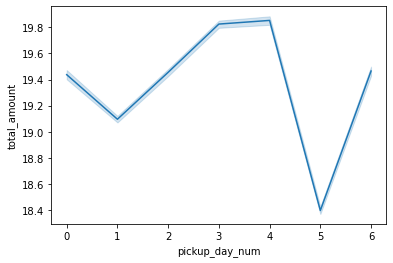

In [42]:
sns.lineplot(x='pickup_day_num',y='total_amount',data=df_train)

### Display most pickup & dropoff passengers zones


In [43]:
top_5_zone=df_train.PULocationID.value_counts(ascending=False).head()
top_5_zone1=df_train.DOLocationID.value_counts(ascending=False).head()
top_5_zone

237    300290
161    272154
236    268202
162    235289
186    229826
Name: PULocationID, dtype: int64

In [44]:
top_5_zone1

236    279810
237    268958
161    255417
170    198070
162    197981
Name: DOLocationID, dtype: int64

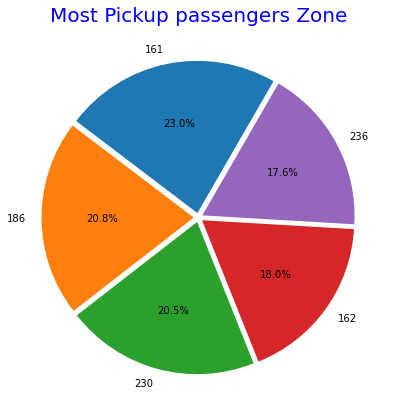

In [45]:
plt.figure(figsize = [9,7])
plt.title('Most Pickup passengers Zone',fontsize=20,color = 'b')

explode = (0.03, 0.03, 0.03, 0.03, 0.03)
labels = ['161','186','230','162','236']


plt.pie(x=top_5_zone, explode=explode,startangle=60, labels=labels,autopct='%0.01f%%')

plt.show()


### Display most drop off zone


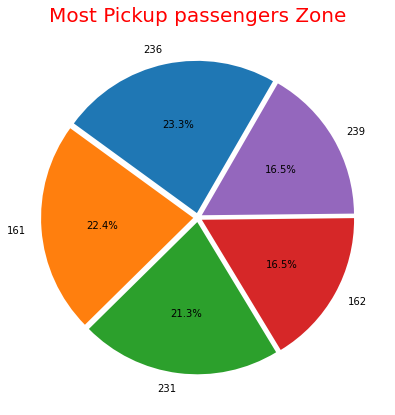

In [46]:
plt.figure(figsize = [9,7])
plt.title('Most Pickup passengers Zone',fontsize=20,color = 'r')

explode = (0.03, 0.03, 0.03, 0.03, 0.03)
labels = ['236','161','231','162','239']


plt.pie(x=top_5_zone1, explode=explode,startangle=60, labels=labels,autopct='%0.01f%%')

plt.show()

### Display most pickup & dropoff hours

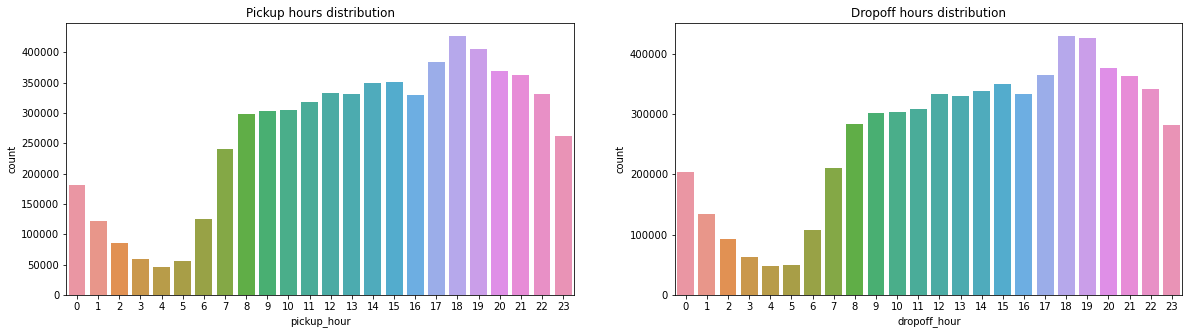

In [47]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup hours distribution')
ax=sns.countplot(x="pickup_hour",data=df_train,ax=ax1)
ax2.set_title('Dropoff hours distribution')
ax=sns.countplot(x="dropoff_hour",data=df_train,ax=ax2)

### Display most pickup & dropoff days

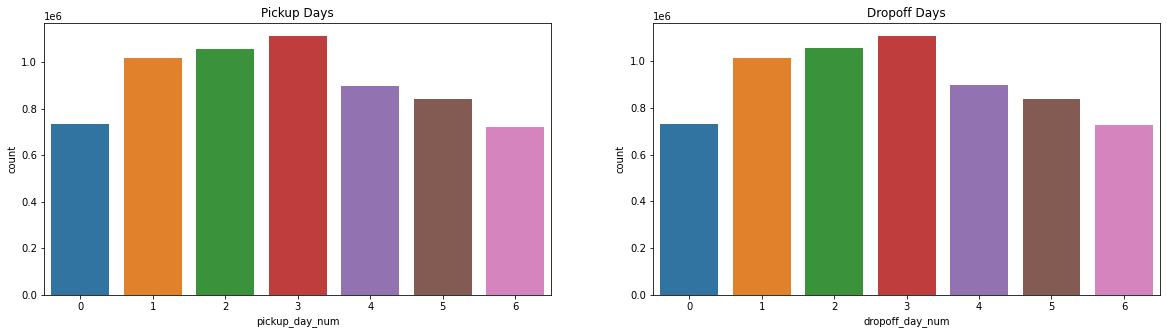

In [48]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day_num",data=df_train,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day_num",data=df_train,ax=ax2)


In [49]:
df_train['pickup_day_num'].value_counts().sort_values(ascending=False)

3    1111128
2    1056538
1    1016107
4     896728
5     839063
0     733356
6     720051
Name: pickup_day_num, dtype: int64

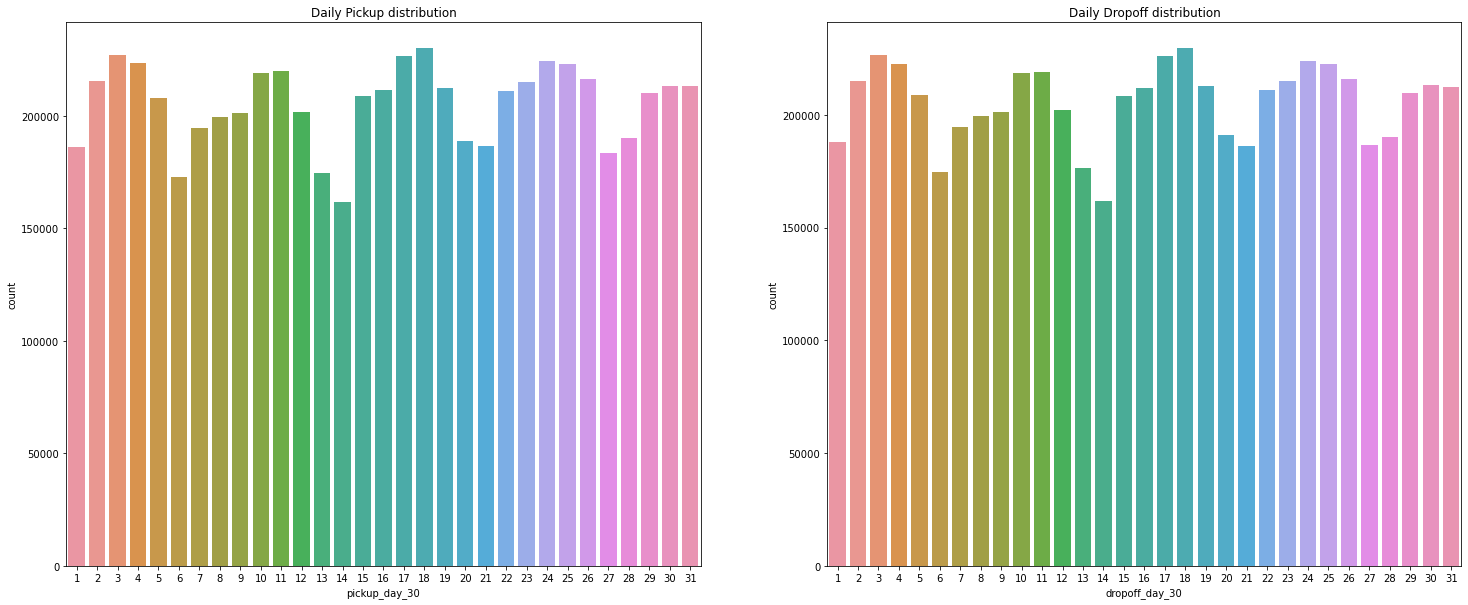

In [50]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(25,10))
ax1.set_title('Daily Pickup distribution')
ax=sns.countplot(x="pickup_day_30",data=df_train,ax=ax1)
ax2.set_title('Daily Dropoff distribution')
ax=sns.countplot(x="dropoff_day_30",data=df_train,ax=ax2)

From the figure above we can conculde many of trips on thursday and Friday

### Display the number of pickup Passengers per hour 


<Figure size 1368x1080 with 0 Axes>

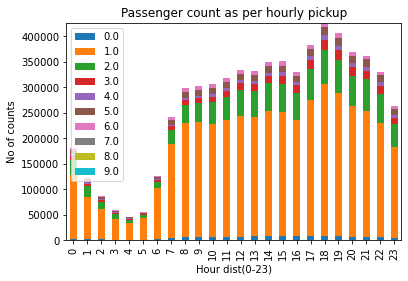

In [51]:
#Passenger count as per hourly pickup
plt.figure(figsize=(19,15))
passenger_per_hour=df_train.groupby(['pickup_hour','passenger_count']).size().unstack()
passenger_per_hour.plot(kind='bar',stacked=True,legend=False)
plt.xlabel('Hour dist(0-23)')
plt.ylabel('No of counts')
plt.title('Passenger count as per hourly pickup')
plt.legend(loc="upper left")

In [52]:
df_train.passenger_count.value_counts()

1.0    4502524
2.0     974229
3.0     263540
5.0     242501
6.0     142255
4.0     125657
0.0     122236
7.0         13
8.0         11
9.0          5
Name: passenger_count, dtype: int64

We can see there is about (122236) of trips have 0 passengers that maybe cancelled for some circumestances
so we should drop the outlier

In [115]:
df_train=df_train[df_train['passenger_count']!=0]
df_val=df_val[df_val['passenger_count']!=0]
df_test=df_test[df_test['passenger_count']!=0]

In [54]:
df_train.passenger_count.value_counts()

1.0    4502524
2.0     974229
3.0     263540
5.0     242501
6.0     142255
4.0     125657
7.0         13
8.0         11
9.0          5
Name: passenger_count, dtype: int64

In [55]:
df_train.RatecodeID.value_counts()

1.0     6043258
2.0      174915
5.0       16976
3.0       14680
4.0         628
99.0        252
6.0          26
Name: RatecodeID, dtype: int64

In [56]:
df_train[df_train.RatecodeID==99]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude,pickup_day_num,dropoff_day_num,pickup_day_30,dropoff_day_30,pickup_hour,dropoff_hour,distance_miles
3688451,2.0,2019-10-23 13:51:42,2019-10-23 13:57:50,1.0,0.89,99.0,N,163,237,2.0,6.0,0.0,0.5,0.0,0.0,0.3,9.3,2.5,163,40.754932,-73.984016,237,40.77360,-73.95660,2,2,23,23,13,13,1.929272
4326426,2.0,2019-10-01 13:26:14,2019-10-01 13:29:58,2.0,0.38,99.0,N,236,236,2.0,4.0,0.0,0.5,0.0,0.0,0.3,7.3,2.5,236,40.764100,-73.956000,236,40.76410,-73.95600,1,1,1,1,13,13,0.000000
869758,2.0,2019-10-23 16:52:21,2019-10-23 16:56:16,1.0,0.00,99.0,N,230,230,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230,40.758880,-73.984820,230,40.75888,-73.98482,2,2,23,23,16,16,0.000000
7034718,2.0,2019-10-16 00:57:03,2019-10-16 01:15:19,1.0,0.00,99.0,N,225,256,2.0,2.5,1.3,0.5,0.0,0.0,0.0,4.3,0.0,225,40.682660,-73.934020,256,40.70820,-73.95710,2,2,16,16,0,1,2.139110
6457740,2.0,2019-10-11 13:57:39,2019-10-11 13:58:00,3.0,0.01,99.0,N,132,132,2.0,2.5,0.0,0.5,0.0,0.0,0.3,3.3,0.0,132,40.639830,-73.778740,132,40.63983,-73.77874,4,4,11,11,13,13,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058049,2.0,2019-10-05 11:31:05,2019-10-05 11:40:00,1.0,1.37,99.0,N,142,50,2.0,7.5,0.0,0.5,0.0,0.0,0.3,10.8,2.5,142,40.774200,-73.984900,50,40.76290,-73.99400,5,5,5,5,11,11,0.914511
4955691,2.0,2019-10-03 06:41:12,2019-10-03 06:45:18,1.0,0.98,99.0,N,107,137,2.0,5.0,0.0,0.5,0.0,0.0,0.3,8.3,2.5,107,40.736800,-73.984500,137,40.73955,-73.97708,3,3,3,3,6,6,0.432432
7144741,2.0,2019-10-14 13:13:52,2019-10-14 13:20:42,1.0,3.94,99.0,N,132,215,2.0,12.5,0.0,0.5,0.0,0.0,0.3,13.3,0.0,132,40.639830,-73.778740,215,40.68094,-73.79089,0,0,14,14,13,13,2.910938
5730883,2.0,2019-10-26 19:40:53,2019-10-26 19:41:04,1.0,0.02,99.0,N,249,249,2.0,52.0,0.0,0.5,0.0,0.0,0.3,55.3,2.5,249,40.734700,-74.004800,249,40.73470,-74.00480,5,5,26,26,19,19,0.000000


Notice there are 252 trips with rate code = 99 and most of trips have 0 passengers and 0 trip_distance ,which mean will drop it of traning set.

In [116]:
#drop the outlier from Ratecode
df_train=df_train[df_train['RatecodeID']!=0]
df_train=df_train[df_train['RatecodeID']<6]

#for alidation-set
df_val=df_val[df_val['RatecodeID']!=0]
df_val=df_val[df_val['RatecodeID']<6]

#For test-set
df_test=df_test[df_test['RatecodeID']!=0]
df_test=df_test[df_test['RatecodeID']<6]

In [117]:
df_train.RatecodeID.value_counts()

1.0    4834780
2.0     139751
5.0      13572
3.0      11724
4.0        502
Name: RatecodeID, dtype: int64

Now no outlier,we can draw it to see data

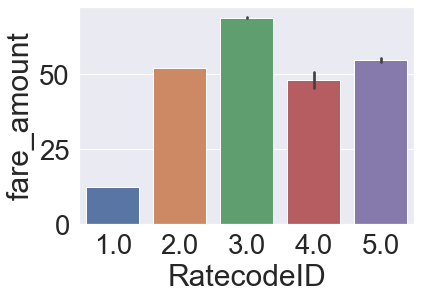

In [97]:
#fare_amount for each rate code id
sns.barplot(y='fare_amount',x='RatecodeID',data=df_train);


### Display the hieghest vendors beside on the number of passengers

In [60]:
df_train.VendorID.value_counts()

2.0    4165050
1.0    2085433
Name: VendorID, dtype: int64

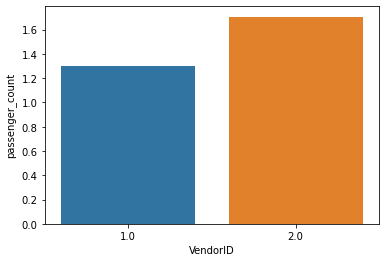

In [61]:
sns.barplot(y='passenger_count',x='VendorID',data=df_train);


In [118]:
#drop the missing values
df_train = df_train.dropna(how = 'any')
df_val = df_val.dropna(how = 'any')
df_test = df_test.dropna(how = 'any')

## Visualizing "univarite feature" to show the distribution and delete the outlier or scalling the feature whenever we need it

## Fare Amount

In [62]:
df_train['fare_amount'].value_counts().sort_values(ascending=False)

6.50     292248
6.00     291367
7.00     288700
7.50     280282
5.50     278156
          ...  
80.30         1
28.75         1
10.74         1
30.14         1
30.45         1
Name: fare_amount, Length: 1662, dtype: int64

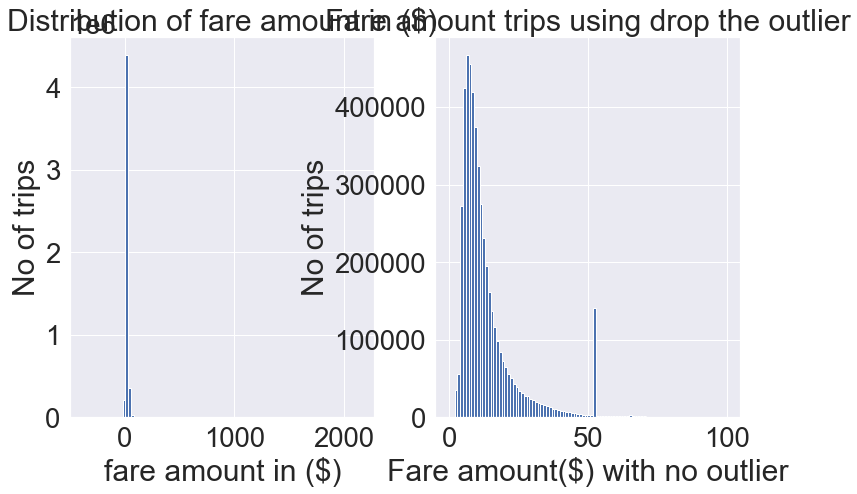

In [119]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram
plt.subplot(121)
plt.hist(df_train['fare_amount'],bins=100)
plt.xlabel('fare amount in ($)')
plt.ylabel('No of trips')
plt.title('Distribution of fare amount in ($)');


#Plotting histogram with a log transformation
plt.subplot(122)

#drop the outliers
df_train=df_train[df_train.fare_amount>0]
df_train=df_train[df_train.fare_amount<100]

plt.hist(df_train['fare_amount'],bins=100)
plt.xlabel('Fare amount($) with no outlier')
plt.ylabel('No of trips')
plt.title('Fare amount trips using drop the outlier');

#Max trips lasted for shorter distances

We see from the histogram above the fare amount between (-50) and ($-60) have a fixed price and there are approximatlly 200000 trips in these prices, let me check in the next step

In [120]:
#for validaion set
df_val=df_val[df_val.fare_amount>0]
df_val=df_val[df_val.fare_amount<100]
#for test-set
df_test=df_test[df_test.fare_amount>0]
df_test=df_test[df_test.fare_amount<100]

## Trip Distance

In [65]:
df_train['trip_distance'].value_counts().sort_values(ascending=False)  

0.90     113133
0.80     112431
1.00     112177
1.10     107225
0.70     106793
          ...  
37.66         1
30.56         1
35.86         1
33.74         1
35.60         1
Name: trip_distance, Length: 3384, dtype: int64

In [121]:
df_train=df_train[df_train.trip_distance>0]
df_train=df_train[df_train.trip_distance<30]

In [122]:
#for validation-set
df_val=df_val[df_val.trip_distance>0]
df_val=df_val[df_val.trip_distance<30]
#For test-set
df_test=df_test[df_test.trip_distance>0]
df_test=df_test[df_test.trip_distance<30]

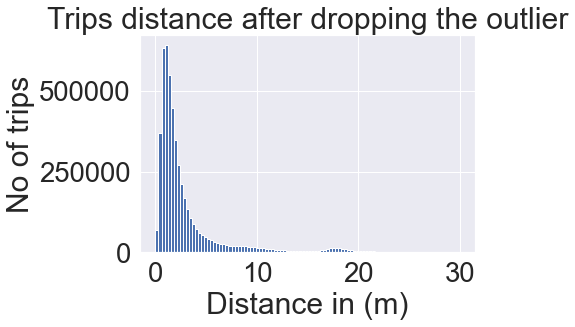

In [123]:
#Display the trip distance
#after dropping the outliers

plt.hist(df_train['trip_distance'].values,bins=100)
plt.xlabel('Distance in (m)')
plt.ylabel('No of trips')
plt.title('Trips distance after dropping the outlier');

#Max trips lasted for shorter distances

In [69]:
#yellow_trip_df['avg_speed_kph']=yellow_trip_df['trip_distance']/yellow_trip_df['trip_duration']
#yellow_trip_df
#df_train['trip_duration'].value_counts()

## Distance_Miles

In [70]:
df_train.distance_miles.value_counts().sort_values(ascending=False) 

0.000000     342880
0.657137      82392
0.639754      40954
1.331967      35739
1.014490      34533
              ...  
13.562272         1
14.868346         1
11.512761         1
7.413671          1
4.261562          1
Name: distance_miles, Length: 14781, dtype: int64

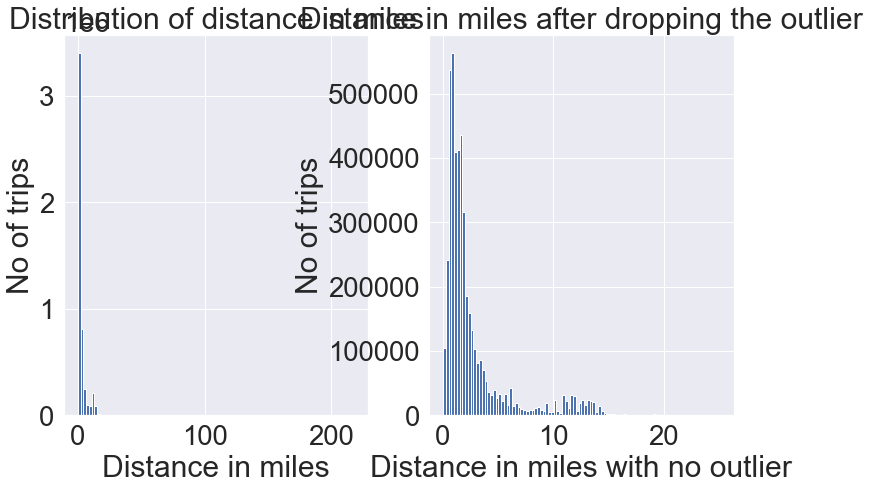

In [124]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 7))
#Plotting histogram all trips in miles
plt.subplot(121)
plt.hist(df_train['distance_miles'],bins=100)
plt.xlabel('Distance in miles')
plt.ylabel('No of trips')
plt.title('Distribution of distance in miles');


#Plotting histogram with a log transformation
plt.subplot(122)

#drop the outliers
df_train=df_train[df_train.distance_miles>0]
df_train=df_train[df_train.distance_miles<30]

plt.hist(df_train['distance_miles'],bins=100)
plt.xlabel('Distance in miles with no outlier')
plt.ylabel('No of trips')
plt.title('Distance in miles after dropping the outlier');


In [125]:
#for val
df_val=df_val[df_val.distance_miles>0]
df_val=df_val[df_val.distance_miles<30]
#for test
df_test=df_test[df_test.distance_miles>2]
df_test=df_test[df_test.distance_miles<30]

### Setting up for modeling and building a baseline:

### Clarify the correlations between whole features

In [73]:
df_train.corr()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude,pickup_day_num,dropoff_day_num,pickup_day_30,dropoff_day_30,pickup_hour,dropoff_hour,distance_miles
VendorID,1.000000,0.162272,0.025879,0.007645,-0.010727,-0.006443,-0.016912,0.018697,-0.883665,0.003793,0.019593,0.009841,-0.008331,0.019708,-0.015217,-0.010727,-0.008521,0.020184,-0.006443,-0.004105,0.009962,0.010896,0.011137,0.001789,0.001834,0.000986,-0.000984,0.012233
passenger_count,0.162272,1.000000,0.013371,0.010997,-0.005913,-0.004618,0.021097,0.013274,-0.139986,-0.002433,-0.004204,0.008078,0.005326,0.011347,0.006017,-0.005913,-0.008934,-0.003399,-0.004618,-0.005944,-0.005036,0.031180,0.031341,-0.000310,-0.000339,0.015473,0.014111,0.006425
trip_distance,0.025879,0.013371,1.000000,0.585796,-0.103719,-0.120506,-0.004118,0.951254,-0.009469,-0.169309,0.550940,0.579876,-0.001498,0.932201,-0.260332,-0.103719,-0.372150,0.546105,-0.120506,-0.223927,0.280789,0.010138,0.010793,0.001858,0.001958,-0.008319,-0.007971,0.746194
RatecodeID,0.007645,0.010997,0.585796,1.000000,-0.047660,-0.068891,-0.004262,0.607424,0.017446,-0.518969,0.378276,0.498640,-0.023353,0.619831,-0.128898,-0.047660,-0.257694,0.340065,-0.068891,-0.151622,0.062227,0.004686,0.004174,0.002211,0.002289,-0.005027,0.003038,0.468140
PULocationID,-0.010727,-0.005913,-0.103719,-0.047660,1.000000,0.026124,-0.024515,-0.098977,0.020503,0.004329,-0.040171,-0.048407,0.001663,-0.087997,0.128582,1.000000,0.230996,0.059737,0.026124,0.077299,0.026995,-0.033517,-0.033783,0.001825,0.001950,0.019427,0.022970,-0.009480
DOLocationID,-0.006443,-0.004618,-0.120506,-0.068891,0.026124,1.000000,-0.028200,-0.126108,0.022799,0.095402,-0.052953,-0.068559,0.001465,-0.113315,0.149941,0.026124,0.084814,-0.010321,1.000000,0.228663,0.118025,-0.029794,-0.030173,0.003033,0.003071,0.018013,0.021842,-0.018726
payment_type,-0.016912,0.021097,-0.004118,-0.004262,-0.024515,-0.028200,1.000000,-0.005338,-0.008378,0.003941,-0.506078,-0.020558,-0.013376,-0.111857,-0.101244,-0.024515,-0.020295,0.051900,-0.028200,0.001535,0.049203,0.025307,0.024844,-0.001987,-0.001968,-0.017397,-0.015423,-0.011456
fare_amount,0.018697,0.013274,0.951254,0.607424,-0.098977,-0.126108,-0.005338,1.000000,-0.007583,-0.242350,0.576388,0.580800,-0.007286,0.976048,-0.241890,-0.098977,-0.337669,0.484987,-0.126108,-0.231163,0.223682,0.005959,0.006913,0.003487,0.003486,0.005771,0.011146,0.703660
extra,-0.883665,-0.139986,-0.009469,0.017446,0.020503,0.022799,-0.008378,-0.007583,1.000000,0.036858,0.014571,0.001921,0.001450,0.017410,0.153159,0.020503,-0.016267,-0.049823,0.022799,-0.000511,-0.024817,-0.062764,-0.062342,-0.000899,-0.001018,0.127198,0.124815,0.000894
mta_tax,0.003793,-0.002433,-0.169309,-0.518969,0.004329,0.095402,0.003941,-0.242350,0.036858,1.000000,-0.160476,-0.330510,-0.001692,-0.256905,0.190375,0.004329,0.009728,0.000493,0.095402,0.070922,0.204150,-0.003782,-0.003681,-0.002157,-0.002165,0.015403,0.010713,-0.120730


In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5833375 entries, 4105733 to 4500015
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               float64       
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  LocationID      

In [75]:
df_train.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,LocationID,PUlatitude,PUlogtitude,LocationID1,DOlatitude,DOlogtitude,pickup_day_num,dropoff_day_num,pickup_day_30,dropoff_day_30,pickup_hour,dropoff_hour,distance_miles
count,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06,5.833375e+06
mean,1.666753e+00,1.572608e+00,3.088294e+00,1.035834e+00,1.633025e+02,1.610083e+02,1.267180e+00,1.360543e+01,1.133579e+00,4.986377e-01,2.336767e+00,3.864815e-01,2.999541e-01,1.982949e+01,2.352405e+00,1.633025e+02,4.075277e+01,-7.396708e+01,1.610083e+02,4.075459e+01,-7.396922e+01,2.915785e+00,2.921125e+00,1.608065e+01,1.607739e+01,1.397708e+01,1.402013e+01,2.727722e+00
std,4.713739e-01,1.173471e+00,3.813871e+00,2.208644e-01,6.502161e+01,6.947980e+01,4.567385e-01,1.087571e+01,1.259242e+00,2.733376e-02,2.700510e+00,1.825074e+00,3.709459e-03,1.372670e+01,5.892315e-01,6.502161e+01,3.718769e-02,4.723475e-02,6.947980e+01,3.826780e-02,4.104664e-02,1.877097e+00,1.879899e+00,8.962574e+00,8.962684e+00,6.006930e+00,6.107767e+00,3.204872e+00
min,1.000000e+00,1.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-1.662000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e-01,0.000000e+00,1.000000e+00,4.051128e+01,-7.425057e+01,1.000000e+00,4.051128e+01,-7.425057e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.917139e-02
25%,1.000000e+00,1.000000e+00,1.080000e+00,1.000000e+00,1.250000e+02,1.130000e+02,1.000000e+00,7.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.184000e+01,2.500000e+00,1.250000e+02,4.073680e+01,-7.399170e+01,1.130000e+02,4.073680e+01,-7.399170e+01,1.000000e+00,1.000000e+00,8.000000e+00,8.000000e+00,1.000000e+01,1.000000e+01,8.946543e-01
50%,2.000000e+00,1.000000e+00,1.730000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.536000e+01,2.500000e+00,1.620000e+02,4.075493e+01,-7.398150e+01,1.620000e+02,4.075493e+01,-7.397708e+01,3.000000e+00,3.000000e+00,1.600000e+01,1.600000e+01,1.500000e+01,1.500000e+01,1.597205e+00
75%,2.000000e+00,2.000000e+00,3.150000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.550000e+01,2.500000e+00,5.000000e-01,3.060000e+00,0.000000e+00,3.000000e-01,2.136000e+01,2.500000e+00,2.330000e+02,4.076748e+01,-7.396020e+01,2.330000e+02,4.076956e+01,-7.395670e+01,4.000000e+00,4.000000e+00,2.400000e+01,2.400000e+01,1.900000e+01,1.900000e+01,2.791053e+00
max,2.000000e+00,9.000000e+00,2.999000e+01,6.000000e+00,2.630000e+02,2.630000e+02,4.000000e+00,9.950000e+01,6.250000e+01,1.942000e+01,3.535000e+02,9.105000e+02,3.000000e-01,9.608000e+02,2.750000e+00,2.630000e+02,4.095641e+01,-7.371324e+01,2.630000e+02,4.095641e+01,-7.371324e+01,6.000000e+00,6.000000e+00,3.100000e+01,3.100000e+01,2.300000e+01,2.300000e+01,2.508991e+01


There are alot of variables, Let's pick out just a few columns and start building models.

##  Visualizing "Multivarite features" to understand the relationship between independent (features_X) and dependent (Y_feature= Fare amount).

### The distibution between fare amount and distance miles

Text(0.5, 1.0, 'Fare amount in trip distance-miles')

<Figure size 720x504 with 0 Axes>

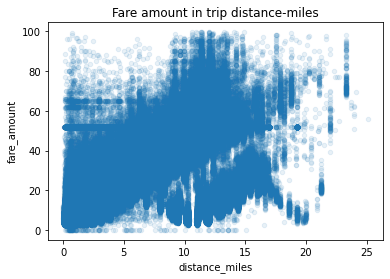

In [76]:
#Plotting to show the fare amount in trip distance in miles
plt.figure(figsize=(10,7))
df_train.plot(kind='scatter',x='distance_miles',y='fare_amount',alpha=0.1)
plt.title('Fare amount in trip distance-miles')

### The distibution between fare amount and passenger counts

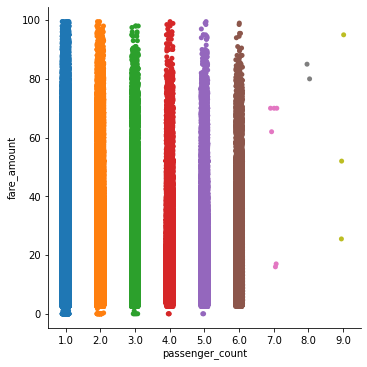

In [77]:
sns.catplot(x='passenger_count',y='fare_amount',data=df_train);

### The distibution between fare amount and trip distance

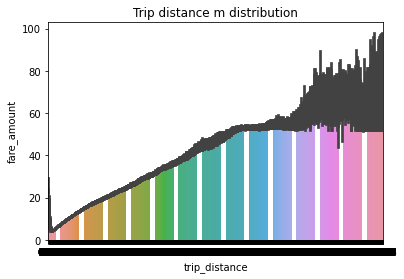

In [78]:
sns.barplot(x='trip_distance',y='fare_amount',data=df_train)
plt.title('Trip distance m distribution');

### The distibution between fare amount over month

<Figure size 432x576 with 0 Axes>

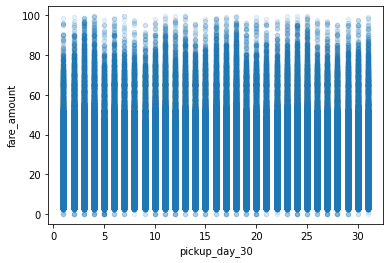

In [79]:
plt.figure(figsize=(6,8))
df_train.plot(kind="scatter", x="pickup_day_30", y="fare_amount", alpha=0.1);

### The distibution between fare amount and weekdays

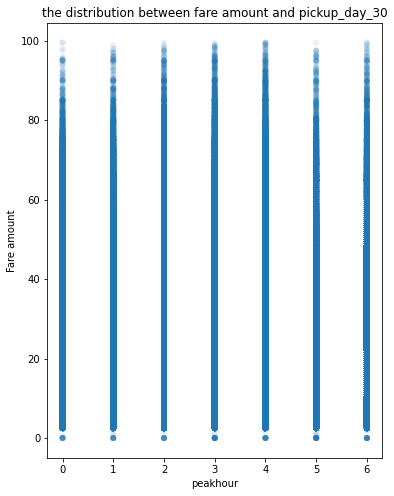

In [80]:
plt.figure(figsize=(6,8))
sns.scatterplot(x='pickup_day_num',y='fare_amount',data=df_train,edgecolor='None',alpha=0.1)
plt.xlabel('peakhour')
plt.ylabel('Fare amount')
plt.title('the distribution between fare amount and pickup_day_30');

### The distibution between fare amount and pickup hours

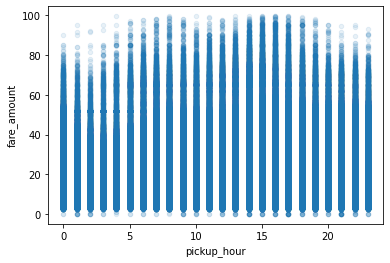

In [81]:
df_train.plot(kind="scatter", x="pickup_hour", y="fare_amount",alpha=0.1);

In [126]:
#drop the outlier from coordinates's training set
df_train=df_train[(df_train['PUlogtitude'] >= -75) & (df_train['PUlogtitude'] <= -72)]
df_train=df_train[(df_train['DOlogtitude'] >= -75) & (df_train['DOlogtitude'] <= -72)]
df_train=df_train[(df_train['PUlatitude'] >= 40) & (df_train['PUlatitude'] <= 42)]
df_train=df_train[(df_train['DOlatitude'] >=40) & (df_train['DOlatitude'] <= 42)]

In [127]:
df_val=df_val[(df_val['PUlogtitude'] >= -75) & (df_val['PUlogtitude'] <= -72)]
df_val=df_val[(df_val['DOlogtitude'] >= -75) & (df_val['DOlogtitude'] <= -72)]
df_val=df_val[(df_val['PUlatitude'] >= 40) & (df_val['PUlatitude'] <= 42)]
df_val=df_val[(df_val['DOlatitude'] >=40) & (df_val['DOlatitude'] <= 42)]

In [128]:
df_test=df_test[(df_test['PUlogtitude'] >= -75) & (df_test['PUlogtitude'] <= -72)]
df_test=df_test[(df_test['DOlogtitude'] >= -75) & (df_test['DOlogtitude'] <= -72)]
df_test=df_test[(df_test['PUlatitude'] >= 40) & (df_test['PUlatitude'] <= 42)]
df_test=df_test[(df_test['DOlatitude'] >=40) & (df_test['DOlatitude'] <= 42)]

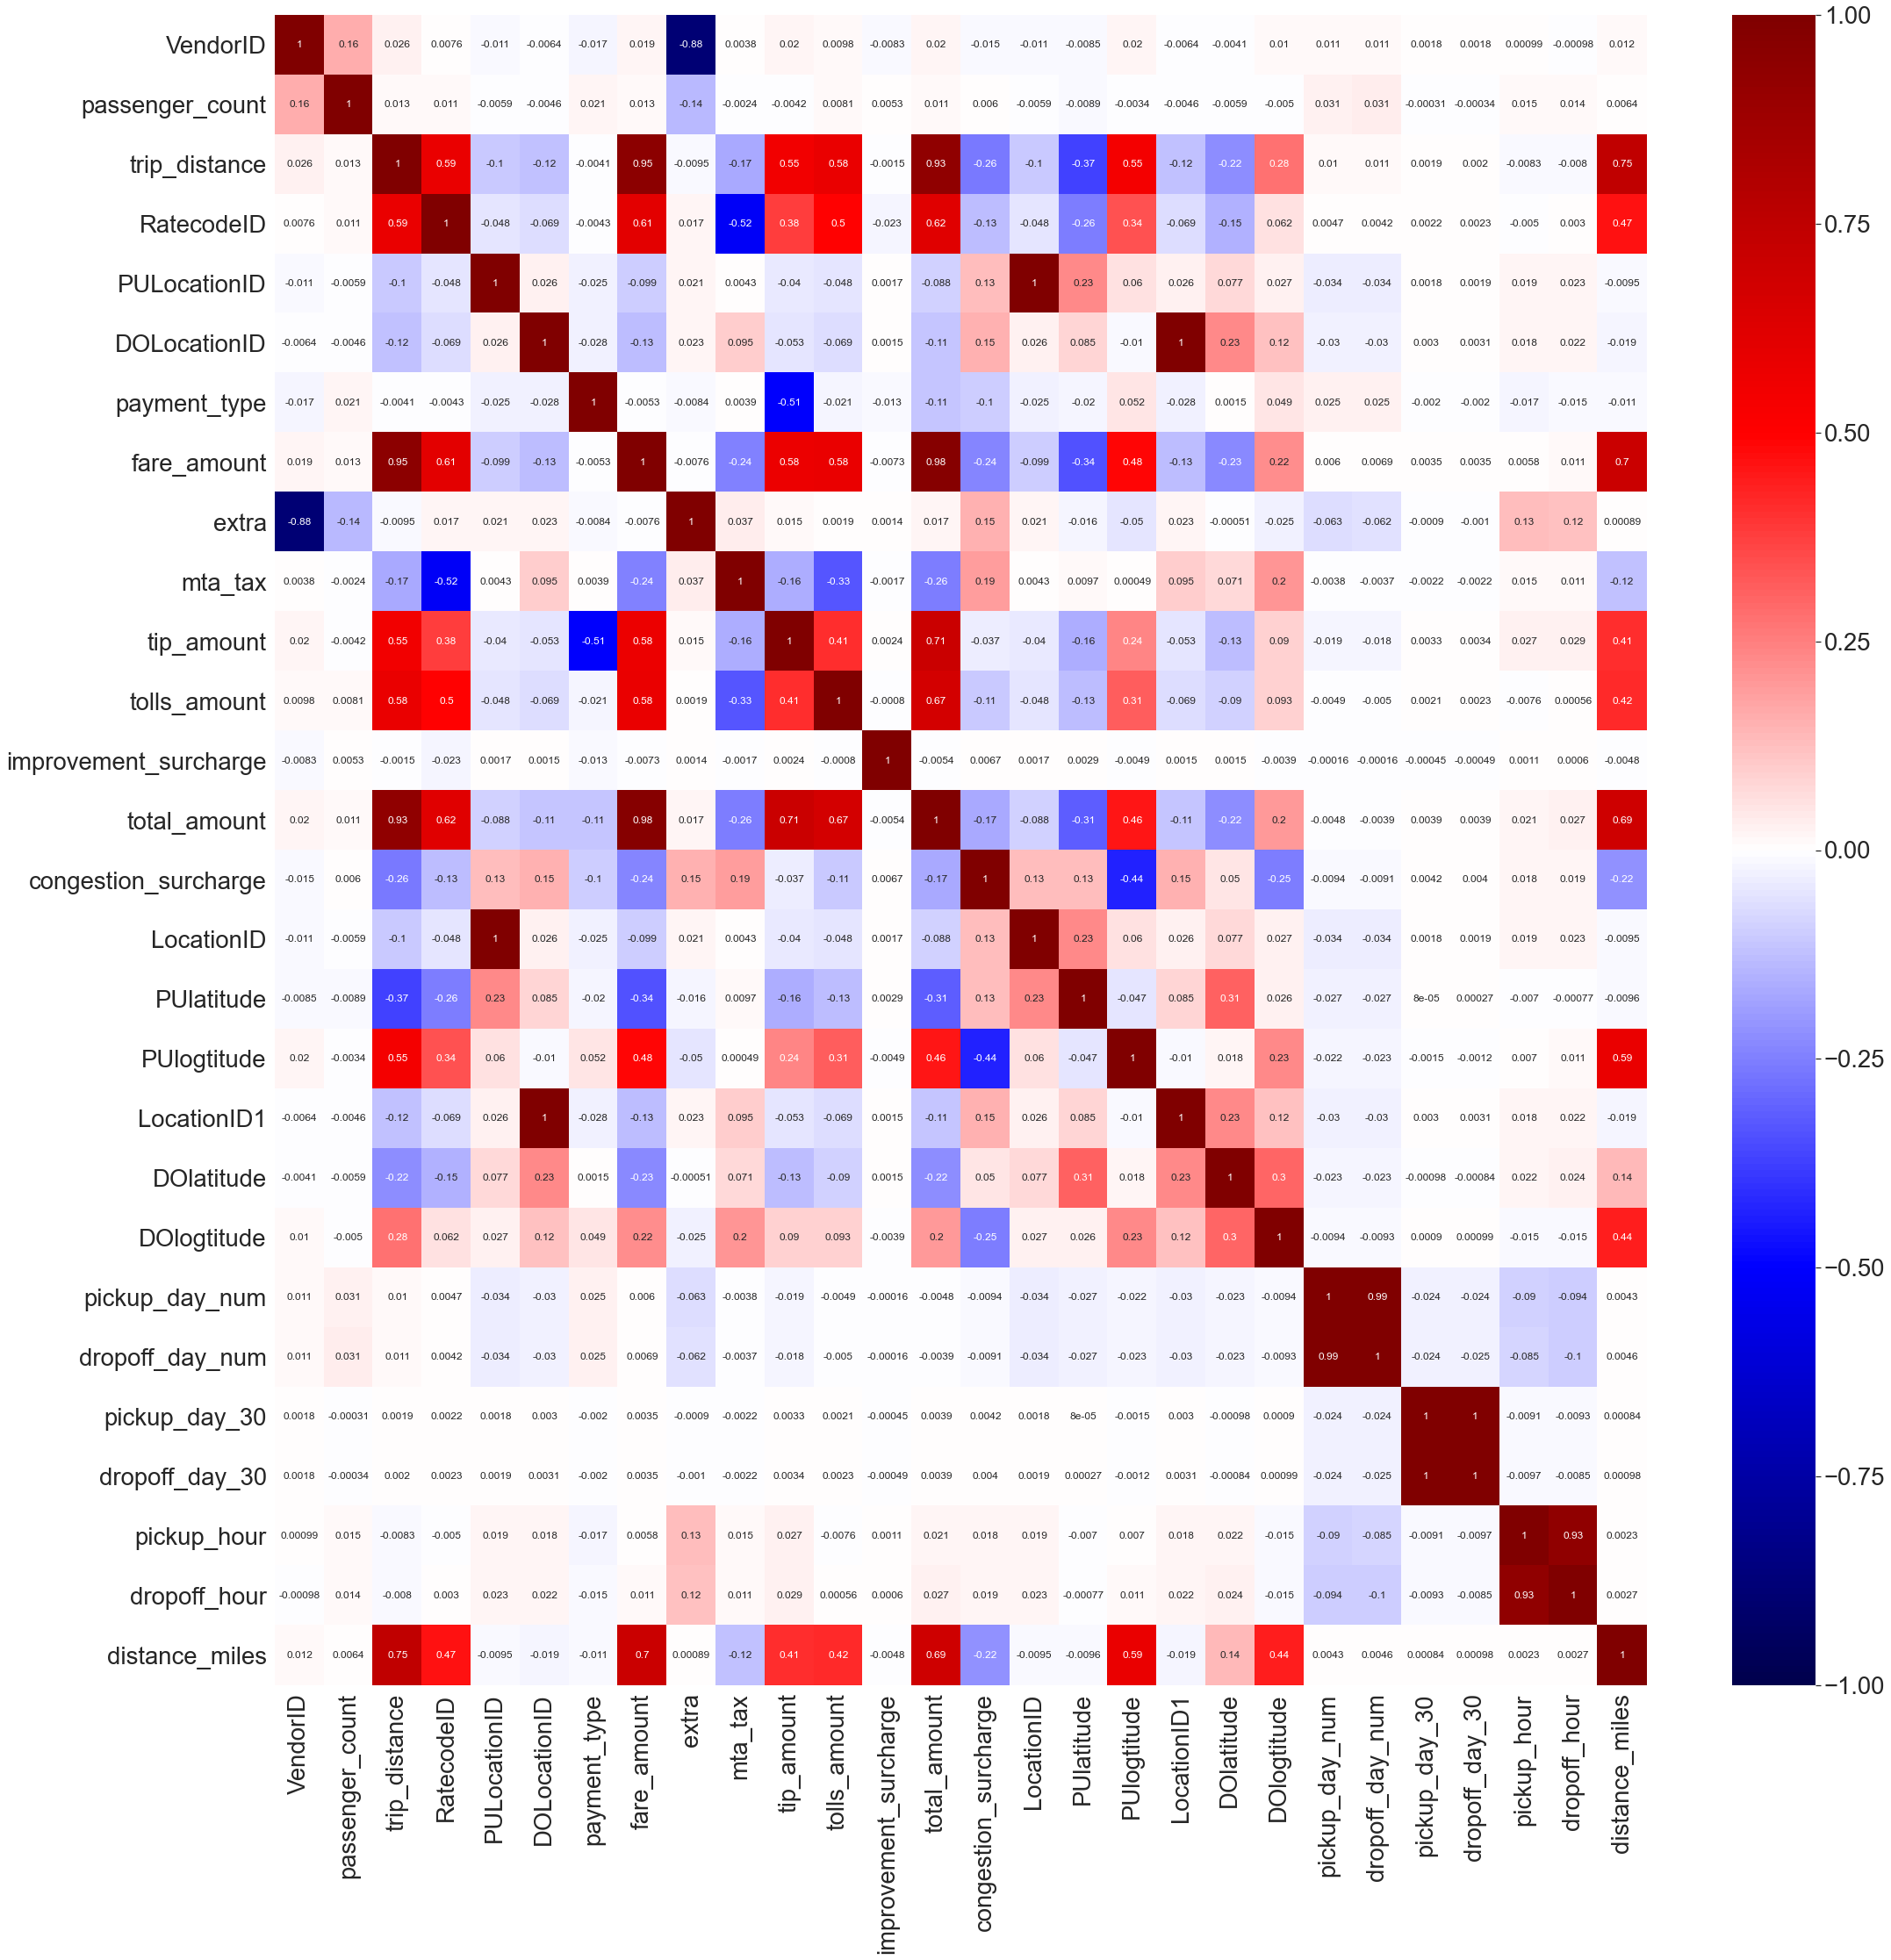

In [85]:
#Corr matrix for whole df_train features
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=(35,35)) 
sns.heatmap(df_train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"size":12});

In [129]:
df_train.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'LocationID', 'PUlatitude',
       'PUlogtitude', 'LocationID1', 'DOlatitude', 'DOlogtitude',
       'pickup_day_num', 'dropoff_day_num', 'pickup_day_30', 'dropoff_day_30',
       'pickup_hour', 'dropoff_hour', 'distance_miles'],
      dtype='object')

In [130]:
smaller_df=df_train.loc[:,['distance_miles','fare_amount','PUlatitude',
       'PUlogtitude','DOlatitude', 'DOlogtitude','pickup_day_num','pickup_day_30','pickup_hour']]

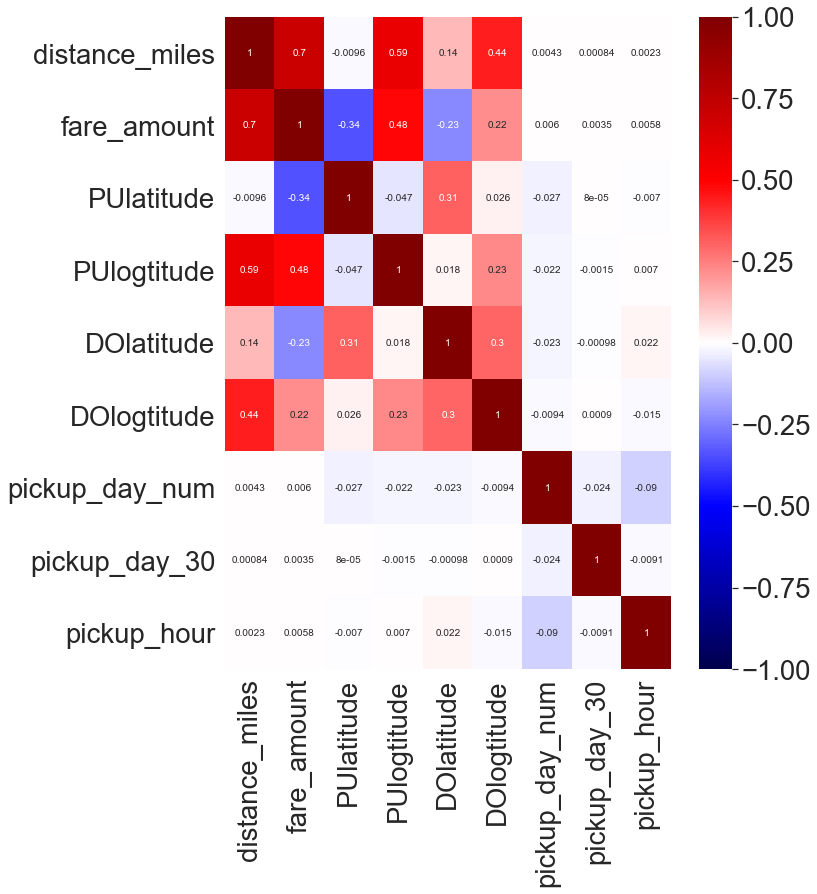

In [88]:
#To see a better corr matrix
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=(10,12)) 
sns.heatmap(smaller_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"size":10});

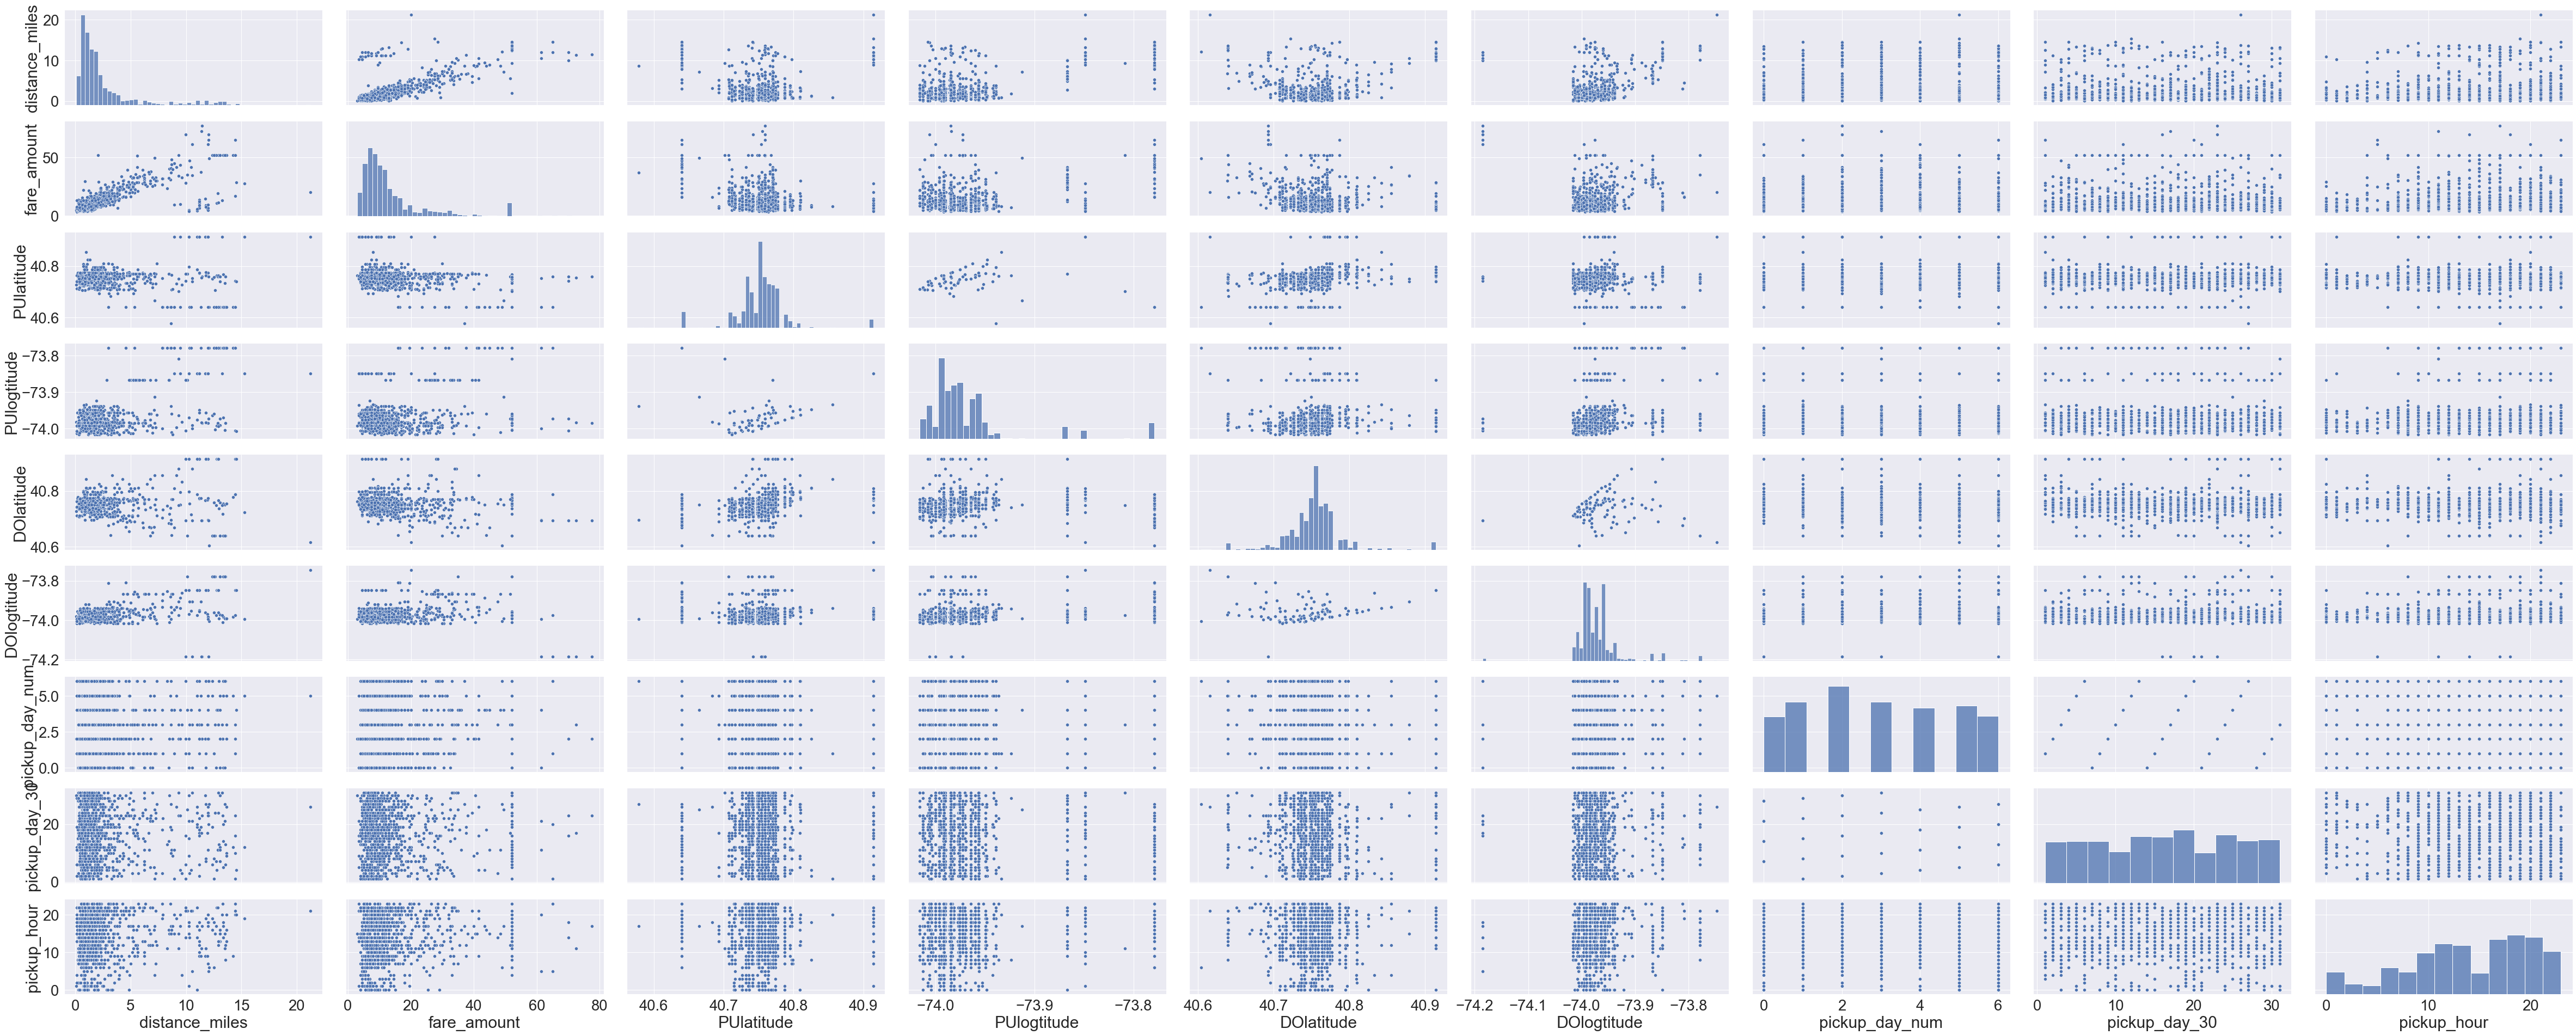

In [89]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(smaller_df[:1000], height=3, aspect=2.5);

In [131]:
# The figure above display the correlation between the features and the target, for this i choose only two features
x_train,y_train = df_train.loc[:,['distance_miles','PUlatitude',
       'PUlogtitude','DOlatitude', 'DOlogtitude','pickup_day_num','pickup_day_30','pickup_hour']], df_train['fare_amount']
x_val,y_val = df_val.loc[:,['distance_miles','PUlatitude',
       'PUlogtitude','DOlatitude', 'DOlogtitude','pickup_day_num','pickup_day_30','pickup_hour']], df_val['fare_amount']
x_test,y_test = df_test.loc[:,['distance_miles','PUlatitude',
       'PUlogtitude','DOlatitude', 'DOlogtitude','pickup_day_num','pickup_day_30','pickup_hour']], df_test['fare_amount']

### Ordinary Least Squares Regression with Statsmodels

In [132]:
# Create your model
model = sm.OLS(y_train, x_train)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            fare_amount   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                          3.483e+06
Date:                Sat, 11 Dec 2021   Prob (F-statistic):                        0.00
Time:                        10:22:45   Log-Likelihood:                     -1.5426e+07
No. Observations:             4667040   AIC:                                  3.085e+07
Df Residuals:                 4667032   BIC:                                  3.085e+07
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
distance_miles     2.8443      0.001   2649.873      0.000       2.842       2.846
PUlatitude       -62.8752      0.085   -737.811      0.000     -63.042     -62.708
PUlogtitude      -13.9481      0.066   -212.017      0.000     -14.077     -13.819
DOlatitude       -47.2892      0.082   -579.552      0.000     -47.449     -47.129
DOlogtitude      -46.8274      0.059   -787.058      0.000     -46.944     -46.711
pickup_day_num    -0.0574      0.002    -35.117      0.000      -0.061      -0.054
pickup_day_30      0.0031      0.000      9.028      0.000       0.002       0.004
pickup_hour        0.0054      0.001     10.537      0.000       0.004       0.006
==============================================================================
Omnibus:                   927451.020   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7307483.951
Skew:                           0.744   Prob(JB):                         0.00
Kurtosis:                       8.947   Cond. No.                     4.04e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [199]:
# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
tr_score = lr_model.score(x_train, y_train)

# score fit model on validation data
val_score = lr_model.score(x_val, y_val)
test_score = lr_model.score(x_test, y_test)

# report results
print('\nTraining R^2 score fron first baseline was:', tr_score)
print('\nValidation R^2 score fron first baseline was:', val_score)
print('\nTest R^2 score was:', test_score)

print('\nFeature coefficient results: \n')
for feature, coef in zip(x_val.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 
        


Training R^2 score fron first baseline was: 0.6660340204010053

Validation R^2 score fron first baseline was: 0.6651685635045641

Test R^2 score was: 0.5859199551483172

Feature coefficient results: 

distance_miles : 2.39
PUlatitude : -73.45
PUlogtitude : 16.11
DOlatitude : -69.71
DOlogtitude : -5.81
pickup_day_num : -0.04
pickup_day_30 : 0.00
pickup_hour : 0.01


we need to enhance this model more

From the above figure we see the scores suggest that the model found some important features and marked all other features with a zero coefficient, as we will drop it from the model

## Features Engineering - Polynomial Regression

## Adding categrical feature after transfer it to dummy variables

In [149]:
#add a new features after transferd it to dummy variables and chech the score
x1_train = x_train.copy()
'''
x1_train['store_and_fwd_flag'] = df_train['store_and_fwd_flag']
f= pd.get_dummies(df_train['store_and_fwd_flag'],drop_first=True)
x1_train = pd.concat([x1_train,f],axis=1)
'''
x1_train['RatecodeID']=df_train['RatecodeID']
d= pd.get_dummies(df_train['RatecodeID'],drop_first=True)
x1_train = pd.concat([x1_train,d],axis=1)

x1_train['VendorID']=df_train['VendorID']
v= pd.get_dummies(df_train['VendorID'],drop_first=True)
x1_train = pd.concat([x1_train,v],axis=1)


#for val-set
'''
x1_val['store_and_fwd_flag'] = df_val['store_and_fwd_flag']
f1= pd.get_dummies(df_val['store_and_fwd_flag'],drop_first=True)
x1_val = pd.concat([x1_val,f1],axis=1)
'''
x1_val = x_val.copy()
x1_val['RatecodeID']=df_val['RatecodeID']
d1 = pd.get_dummies(df_val['RatecodeID'],drop_first=True)
x1_val = pd.concat([x1_val,d1],axis=1)

x1_val['VendorID']=df_val['VendorID']
v1 = pd.get_dummies(df_val['VendorID'],drop_first=True)
x1_val = pd.concat([x1_val,v1],axis=1)

#For test set
'''
x1_test['store_and_fwd_flag'] = df_test['store_and_fwd_flag']
f2= pd.get_dummies(df_test['store_and_fwd_flag'],drop_first=True)
x1_test = pd.concat([x1_test,f2],axis=1)
'''
x1_test = x_test.copy()
x1_test['RatecodeID']=df_test['RatecodeID']
d2= pd.get_dummies(df_test['RatecodeID'],drop_first=True)
x1_test = pd.concat([x1_test,d2],axis=1)

x1_test['VendorID']=df_test['VendorID']
v2 = pd.get_dummies(df_test['VendorID'],drop_first=True)
x1_test= pd.concat([x1_test,v2],axis=1)

In [150]:
lr_model.fit(x1_train, y_train)
tr_score1 = lr_model.score(x1_train, y_train)

# score fit model on validation data
val_score1 = lr_model.score(x1_val, y_val)

# report results
print('\nTraining R^2 score after transfer categorical features to dummy variables is:', tr_score1)
print('\nValidation R^2 score after transfer categorical features to dummy variables is:', val_score1)

print('\nFeature coefficient results: \n')
for feature, coef in zip(x1_val.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score after transfer categorical features to dummy variables is: 0.7067418279475973

Validation R^2 score after transfer categorical features to dummy variables is: 0.7070828313586122

Feature coefficient results: 

distance_miles : 1.92
PUlatitude : -59.94
PUlogtitude : 14.96
DOlatitude : -62.24
DOlogtitude : 8.88
pickup_day_num : -0.03
pickup_day_30 : 0.00
pickup_hour : 0.02
RatecodeID : 8.36
2.0 : 2.78
3.0 : 21.05
4.0 : -3.77
5.0 : -6.30
VendorID : 0.07
2.0 : 0.07


## Adding polynomial Features

In [151]:
x2_train = x1_train.copy()

In [152]:
x2_val = x1_val.copy()
x2_test = x1_test.copy()

In [153]:
#add a new feature to see how the number of passengers will affect on the fare_amount 
x2_train['is_van'] = np.where(df_train['passenger_count'] >= 2, 1, 0)
x2_val['is_van'] = np.where(df_val['passenger_count'] >= 2, 1, 0)

#for test-set
x2_test['is_van'] = np.where(df_test['passenger_count'] >= 2, 1, 0)

print(df_train.passenger_count.mode())

0    1.0
dtype: float64


In [154]:
# Dafine a function to set is the trip in peak hours or not?
def peakHour(h): 
    if h >= 17 and h<=20:
        return 1
    elif h >= 8 and h <= 15:
        return 1
    else:
        return 0

In [155]:
#add anthor feature to see how Peak hours will effect on the fare_amount 
x2_train['peakHours'] = df_train.loc[:,'pickup_hour'].apply(peakHour)
x2_val['peakHours'] = df_val.loc[:,'pickup_hour'].apply(peakHour)
#For test-set
x2_test['peakHours'] = df_test.loc[:,'pickup_hour'].apply(peakHour)

print(df_train_val.pickup_hour.mode())

0    18
dtype: int64


In [156]:
# add more featurs to see how the peak days will effect also on the fare amount 
def peakDays(d): 
    if d >= 1 and d < 4:
        return 1
    else:
        return 0

In [157]:
x2_train['peakDays'] = df_train.loc[:,'pickup_day_num'].apply(peakDays)
x2_val['peakDays'] = df_val.loc[:,'pickup_day_num'].apply(peakDays)

#For test-set
x2_test['peakDays'] = df_test.loc[:,'pickup_day_num'].apply(peakDays)

print(df_train.pickup_day_num.mode())


0    3
dtype: int64


In [158]:
def isWeekend(w): 
    if w >= 2 and w < 5:
        return 1
    elif w >=7 and w<=12:
        return 1
    elif w>= 15 and w<= 19:
        return 1 
    elif w>= 23 and w<= 27:
        return 1
    elif w>= 29 and w <= 31:
        return 1
    else:
        return 0

In [159]:
x2_train['isWeekend'] = df_train.loc[:,'pickup_day_30'].apply(isWeekend)
x2_val['isWeekend'] = df_val.loc[:,'pickup_day_30'].apply(isWeekend)
#For test-set
x2_test['isWeekend'] = df_test.loc[:,'pickup_day_30'].apply(isWeekend)

print(df_train.pickup_day_30.mode())

0    18
dtype: int64


In [160]:
x2_train.columns

Index(['distance_miles',     'PUlatitude',    'PUlogtitude',     'DOlatitude',
          'DOlogtitude', 'pickup_day_num',  'pickup_day_30',    'pickup_hour',
           'RatecodeID',              2.0,              3.0,              4.0,
                    5.0,       'VendorID',              2.0,         'is_van',
            'peakHours',       'peakDays',      'isWeekend'],
      dtype='object')

In [161]:
x2_test.columns

Index(['distance_miles',     'PUlatitude',    'PUlogtitude',     'DOlatitude',
          'DOlogtitude', 'pickup_day_num',  'pickup_day_30',    'pickup_hour',
           'RatecodeID',              2.0,              3.0,              4.0,
                    5.0,       'VendorID',              2.0,         'is_van',
            'peakHours',       'peakDays',      'isWeekend'],
      dtype='object')

In [162]:
lr_model.fit(x2_train, y_train)
tr_score2 = lr_model.score(x2_train, y_train)

# score fit model on validation data
val_score2 = lr_model.score(x2_val, y_val)

# report results
print('\nTraining R^2 score after adding polynomial features is:', tr_score2)
print('\nValidation R^2 score after adding polynomial features is:', val_score2)

print('\nFeature coefficient results: \n')
for feature, coef in zip(x2_val.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score after adding polynomial features is: 0.7089926925667064

Validation R^2 score after adding polynomial features is: 0.7092938783411578

Feature coefficient results: 

distance_miles : 1.94
PUlatitude : -61.16
PUlogtitude : 14.28
DOlatitude : -62.75
DOlogtitude : 9.02
pickup_day_num : 0.01
pickup_day_30 : 0.00
pickup_hour : 0.01
RatecodeID : 8.33
2.0 : 2.62
3.0 : 20.88
4.0 : -3.67
5.0 : -6.26
VendorID : 0.06
2.0 : 0.06
is_van : 0.19
peakHours : 0.95
peakDays : 0.32
isWeekend : 0.35


## Adding polynomial terms or transformations

One of the first things that we looked for in the pairplot was evidence about the relationship between each feature and the target. In certain features like 'congestion_surcharge' and 'extra', we notice an upward-curved relationship rather than a simple linear correspondence. This suggests that we should add quadratic polynomial terms or transformations for those features, allowing us to express that non-linear relationship while still using linear regression as our model.

In [171]:
x3_train = x2_train.copy()
x3_train['dc'] = x3_train['distance_miles'] ** 3
x3_train['ph'] = x3_train['peakHours'] ** 3
x3_train['pd'] = x3_train['peakDays'] ** 3
x3_train['iw'] = x3_train['isWeekend'] ** 3
x3_train['pu'] = x3_train['PUlatitude'] ** 3
x3_train['do'] = x3_train['DOlatitude'] **3

#For val-set
x3_val = x2_val.copy()
x3_val['dc'] = x3_val['distance_miles'] ** 3
x3_val['ph'] = x3_val['peakHours'] ** 3
x3_val['pd'] = x3_val['peakDays'] ** 3
x3_val['iw'] = x3_val['isWeekend'] ** 3
x3_val['pu'] = x3_val['PUlatitude'] ** 3
x3_val['do'] = x3_val['DOlatitude'] ** 3


#For tset-set
x3_test = x2_test.copy()
x3_test['dc'] = x3_test['distance_miles'] ** 3
x3_test['ph'] = x3_test['peakHours'] ** 3
x3_test['pd'] = x3_test['peakDays'] ** 3
x3_test['iw'] = x3_test['isWeekend'] ** 3
x3_test['pu'] = x3_test['PUlatitude'] **3
x3_test['do'] = x3_test['DOlatitude'] ** 3

In [172]:
lr_model.fit(x3_train, y_train)
tr_score3 = lr_model.score(x3_train, y_train)

# score fit model on validation data
val_score3 = lr_model.score(x3_val, y_val)

# report results
print('\nTraining R^2 score after adding polynomial transformation is:', tr_score3)
print('\nValidation R^2 score after adding polynomial transformation is:', val_score3)

print('\nFeature coefficient results: \n')
for feature, coef in zip(x3_val.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score after adding polynomial transformation is: 0.8142763258322532

Validation R^2 score after adding polynomial transformation is: 0.8142810531178104

Feature coefficient results: 

distance_miles : 4.08
PUlatitude : 40094.61
PUlogtitude : 36.97
DOlatitude : 27444.19
DOlogtitude : 6.40
pickup_day_num : 0.04
pickup_day_30 : 0.00
pickup_hour : 0.01
RatecodeID : 7.90
2.0 : 3.15
3.0 : 13.79
4.0 : 1.69
5.0 : -6.97
VendorID : 0.05
2.0 : 0.05
is_van : 0.17
peakHours : 0.54
peakDays : 0.17
isWeekend : 0.20
dc : -0.01
ph : 0.54
pd : 0.17
iw : 0.20
pu : -8.06
do : -5.52


## Adding interaction terms
With our current feature set, each feature value has no influence over how the model views other features' values. Each feature is treated as a completely independent quantity. However, there may easily be interaction effects present, in which the impact of one feature may dependent on the current value of a different feature.

In [209]:
x4_train = x3_train.copy()

# multiplicative interaction
x4_train['h-d'] = x4_train['peakHours'] * x4_train['distance_miles']
x4_train['D_h'] = x4_train['isWeekend'] * x4_train['distance_miles']
x4_train['D_h'] = x4_train['peakDays'] * x4_train['distance_miles']
x4_train['i_v'] = x4_train['is_van'] * x4_train['distance_miles']

#For val-set
x4_val = x3_val.copy()

x4_val['h-d'] = x4_val['peakHours'] * x4_val['distance_miles']
x4_val['D_h'] = x4_val['isWeekend'] * x4_val['distance_miles']
x4_val['D_h'] = x4_val['peakDays'] * x4_val['distance_miles']
x4_val['i_v'] = x4_val['is_van'] * x4_val['distance_miles']

#for Test set
x4_test = x3_test.copy()
# multiplicative interaction
x4_test['h-d'] = x4_test['peakHours'] * x4_test['distance_miles']
x4_test['D_h'] = x4_test['isWeekend'] * x4_test['distance_miles']
x4_test['D_h'] = x4_test['peakDays'] * x4_test['distance_miles']
x4_test['i_v'] = x4_test['is_van'] * x4_test['distance_miles']


In [210]:
lr_model.fit(x4_train, y_train)
tr_score4 = lr_model.score(x4_train, y_train)

# score fit model on validation data
val_score4 = lr_model.score(x4_val, y_val)

# report results
print('\nTraining R^2 score after adding interaction terms is:', tr_score4)
print('\nValidation R^2 score after adding interaction terms is:', val_score4)

print('\nFeature coefficient results: \n')
for feature, coef in zip(x4_train.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score after adding interaction terms is: 0.8149229112557967

Validation R^2 score after adding interaction terms is: 0.8149944617476822

Feature coefficient results: 

distance_miles : 4.21
PUlatitude : 39823.04
PUlogtitude : 36.73
DOlatitude : 27360.98
DOlogtitude : 6.31
pickup_day_num : 0.04
pickup_day_30 : 0.00
pickup_hour : 0.01
RatecodeID : 7.92
2.0 : 3.26
3.0 : 13.89
4.0 : 1.61
5.0 : -6.99
VendorID : 0.05
2.0 : 0.05
is_van : 0.21
peakHours : 0.80
peakDays : 0.19
isWeekend : 0.19
dc : -0.01
ph : 0.80
pd : 0.19
iw : 0.19
pu : -8.00
do : -5.50
h-d : -0.18
D_h : -0.02
i_v : -0.01


In [211]:
x5_train=x4_train.drop(['pickup_day_num','pickup_day_30','pickup_hour','RatecodeID','VendorID'],axis=1)
x5_val=x4_val.drop(['pickup_day_num','pickup_day_30','pickup_hour','RatecodeID','VendorID'],axis=1)
x5_test=x4_test.drop(['pickup_day_num','pickup_day_30','pickup_hour','RatecodeID','VendorID'],axis=1)

In [212]:
lr_model.fit(x5_train, y_train)
tr_score5 = lr_model.score(x5_train, y_train)

# score fit model on validation data
val_score5 = lr_model.score(x5_val, y_val)

# report results
print('\nTraining R^2 score after adropping unimportance features is:', tr_score5)
print('\nValidation R^2 score after adropping unimportance features is:', val_score5)

print('\nFeature coefficient results: \n')
for feature, coef in zip(x5_val.columns, lr_model.coef_):
    print(feature, ':', f'{coef:.2f}') 


Training R^2 score after adropping unimportance features is: 0.8148392075397392

Validation R^2 score after adropping unimportance features is: 0.8149027541118723

Feature coefficient results: 

distance_miles : 4.21
PUlatitude : 39819.41
PUlogtitude : 36.70
DOlatitude : 27330.15
DOlogtitude : 6.21
2.0 : 11.18
3.0 : 29.69
4.0 : 25.37
5.0 : 24.70
2.0 : 0.10
is_van : 0.22
peakHours : 0.80
peakDays : 0.15
isWeekend : 0.22
dc : -0.01
ph : 0.80
pd : 0.15
iw : 0.22
pu : -8.00
do : -5.50
h-d : -0.18
D_h : -0.02
i_v : -0.01


In [185]:
x5_train.shape,x5_val.shape,x5_test.shape

((4667040, 22), (1166328, 22), (233655, 22))

**Benchmarks that i follow in choosing the best model**:

> 1. Training R^2 score fron first baseline was: 0.6660340204010053

        Validation R^2 score fron first baseline was: 0.6651685635045641

> 3. Training R^2 score after transfer categorical features to dummy variables is: 0.7067418279475973

        Validation R^2 score after transfer categorical features to dummy variables is: 0.7070828313586122
     
> 4. Training R^2 score after adding polynomial features is: 0.7089926925667064

        Validation R^2 score after adding polynomial features is: 0.7092938783411578
     
> 5. Training R^2 score after adding polynomial transformation is: 0.8142763258322532

        Validation R^2 score after adding polynomial transformation is: 0.8142810531178104
    
> 6. Training R^2 score after adding interaction terms is: 0.8149229112557967

        Validation R^2 score after adding interaction terms is: 0.8149944617476822
 

## Standard-scaling Features 

In [213]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [214]:
#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

x6_train = scaler.fit_transform(x5_train.values)
x6_val = scaler.transform(x5_val.values)

tr_score6 = lr_model.score(x6_train, y_train)

val_score6 = lr_model.score(x6_val, y_val)

# report results
print('\nTraining R^2 score after standard scalling is:', tr_score5)
print('\nValidation R^2 score after standard scallingadding interaction terms is:', val_score5)


Training R^2 score after standard scalling is: 0.8148392075397392

Validation R^2 score after standard scallingadding interaction terms is: 0.8149027541118723



Test R^2 score after standard scalling is: 0.7960770396419969


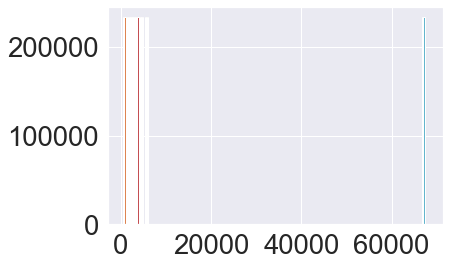

In [215]:
test_score6 = lr_model.score(x5_test, y_test)
print('\nTest R^2 score after standard scalling is:', test_score6)

## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)
plt.hist(x5_test);

## Test Set

In [190]:
x2_test

,distance_miles,PUlatitude,PUlogtitude,DOlatitude,DOlogtitude,pickup_day_num,pickup_day_30,pickup_hour,RatecodeID,2.0,3.0,4.0,5.0,VendorID,2.0,is_van,peakHours,peakDays,isWeekend
3910079,2.465429,40.749800,-73.991700,40.773600,-73.956600,4,25,10,1.0,0,0,0,0,1.0,0,0,1,0,1
602132,2.308406,40.773760,-73.904940,40.795000,-73.939000,4,18,10,2.0,1,0,0,0,1.0,0,0,1,0,1
3915156,2.037713,40.747900,-73.975700,40.773600,-73.956600,0,14,11,1.0,0,0,0,0,1.0,0,0,1,0,0
6452305,10.121126,40.770130,-73.867030,40.639830,-73.778740,4,4,11,1.0,0,0,0,0,2.0,1,0,1,0,1
5381883,2.402670,40.747900,-73.975700,40.714722,-73.989444,3,10,17,1.0,0,0,0,0,2.0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820730,6.212912,40.770130,-73.867030,40.758880,-73.984820,2,2,9,1.0,0,0,0,0,2.0,1,1,1,1,1
516640,3.844685,40.668103,-73.944799,40.715000,-73.984300,6,27,8,1.0,0,0,0,0,2.0,1,0,1,0,1
1255237,2.271796,40.771200,-73.949500,40.763800,-73.991800,6,6,0,1.0,0,0,0,0,2.0,1,0,0,0,0
7161019,5.891839,40.767000,-73.921000,40.765830,-73.808420,1,1,0,1.0,0,0,0,0,2.0,1,0,0,1,0


In [192]:
x5_test.columns

Index(['distance_miles',     'PUlatitude',    'PUlogtitude',     'DOlatitude',
          'DOlogtitude',              2.0,              3.0,              4.0,
                    5.0,              2.0,         'is_van',      'peakHours',
             'peakDays',      'isWeekend',             'dc',             'ph',
                   'pd',             'iw',             'pu',             'do',
                  'h-d',            'D_h'],
      dtype='object')

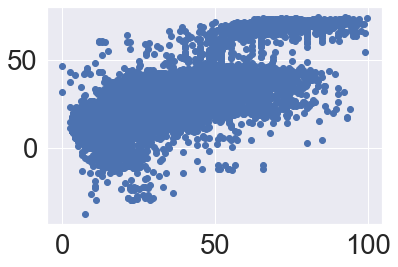

In [218]:
lm = LinearRegression() # construct LinearRegression model object

lm.fit(x5_train, y_train) #fit model to features X_train, target y_train

preds=lm.predict(x5_test) # generate predictions for X_test using fit model

plt.scatter(y_test,preds);
 

In [221]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_test, preds, squared=False)
print(rmse)

6.194654983337808
